In [1]:
import sys

sys.path.append("../../src")

In [2]:
import time

import eda_functions as eda
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from analysis import (
# plot_confusion_matrix,
# plot_prc_auc_curve,
# plot_roc_auc_curve,
# )
from fitpredictgo import FitPredictGo, Results

In [3]:
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Загрузка данных

In [4]:
baseline_model = joblib.load("../../models/baseline_model.joblib")

In [5]:
X_train = pd.read_csv("../../data/baseline/X_train.csv")
X_test = pd.read_csv("../../data/baseline/X_test.csv")
y_train = pd.read_csv("../../data/baseline/y_train.csv")
y_test = pd.read_csv("../../data/baseline/y_test.csv")

## Изучение важности признаков для каждого класса

In [6]:
baseline_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['age_group',
                                                   'pressure_group']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'glucose_level',
                                                   'body_temperature',
                                                   'heart_rate'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [7]:
importance = baseline_model.steps[1][1].coef_
importance

array([[-0.18043596, -0.10237154,  1.09233097, -0.1428078 , -1.69280783,
         0.14492869, -0.12481542,  0.50327382,  0.27512525,  1.20887538,
         0.57568219, -0.01346018],
       [ 0.00635737,  0.2772652 , -0.3920525 ,  0.08065727,  0.9175507 ,
        -0.45113182,  0.17422016, -0.73724213,  0.05446477, -1.06509285,
        -0.6299602 , -0.02490347],
       [ 0.1740786 , -0.17489366, -0.70027847,  0.06215053,  0.77525712,
         0.30620313, -0.04940474,  0.23396831, -0.32959002, -0.14378253,
         0.05427801,  0.03836365]])

In [8]:
features_names = baseline_model.steps[0][1].get_feature_names_out()
features_names

array(['ohe__age_group_older age', 'ohe__age_group_younger age',
       'ohe__pressure_group_hypertension_stage_1',
       'ohe__pressure_group_hypotension', 'ohe__pressure_group_normal',
       'ohe__pressure_group_optimal', 'num__age', 'num__systolic_bp',
       'num__diastolic_bp', 'num__glucose_level', 'num__body_temperature',
       'num__heart_rate'], dtype=object)

In [9]:
feature_importance = pd.DataFrame(abs(importance.T), index=features_names)
feature_importance

,0,1,2
ohe__age_group_older age,0.180436,0.006357,0.174079
ohe__age_group_younger age,0.102372,0.277265,0.174894
ohe__pressure_group_hypertension_stage_1,1.092331,0.392053,0.700278
ohe__pressure_group_hypotension,0.142808,0.080657,0.062151
ohe__pressure_group_normal,1.692808,0.917551,0.775257
ohe__pressure_group_optimal,0.144929,0.451132,0.306203
num__age,0.124815,0.174220,0.049405
num__systolic_bp,0.503274,0.737242,0.233968
num__diastolic_bp,0.275125,0.054465,0.329590
num__glucose_level,1.208875,1.065093,0.143783


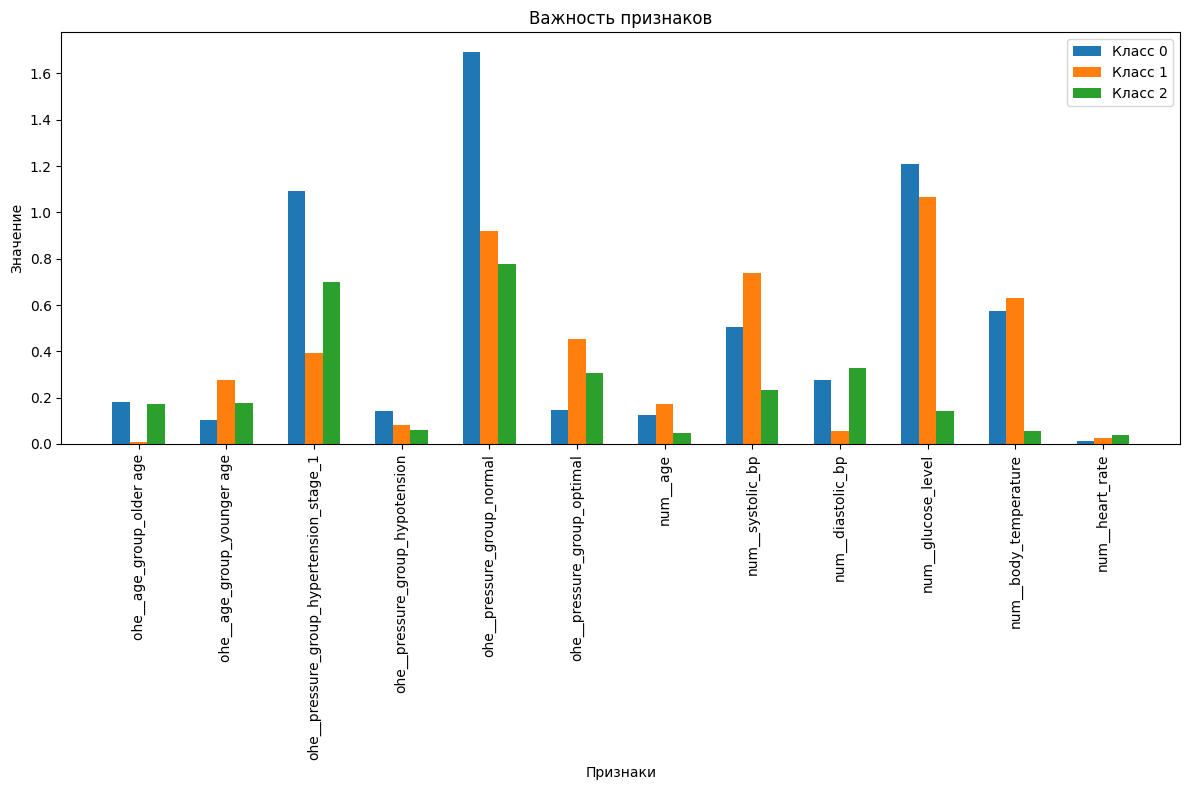

In [10]:
plt.figure(figsize=(12, 8))
bar_width = 0.2
indices = np.arange(len(feature_importance))

for i, col in enumerate(feature_importance.columns):
    plt.bar(
        indices + i * bar_width,
        feature_importance[col],
        width=bar_width,
        label=f"Класс {col}",
    )

plt.title("Важность признаков")
plt.xlabel("Признаки")
plt.ylabel("Значение")
plt.xticks(indices + bar_width, feature_importance.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

В результате анализа важности признаков для каждого класса выявлено:
1. Самый важный признак для класса "Высокий риск" - группа артериального давления 'normal', что весьма странно. Вероятно, имеется слишком много записей с другими признаками, реально влияющими на риск, но с нормальным давлением. Кроме того, среди признаков отсутствуют некоторые группы, которые не были представлены в данных после разбиения на выборки из-за малого размера датасета. 
   - Целесообразно пересмотреть способ разделения на группы по артериальному давлению, например на три группы: "нормальное", "повышенное", "пониженное".
   - Целесообразно рассмотреть вопрос влияния регуляризации (пропробуем её убрать).
2. Зачастую  признак, равноценный для двух классов, например, температура тела или диастолическое давление, играет малую роль для третьего класса. Вероятно, это связано с малой представленностью признака среди записей различных классов. Фактически, это сказывается малый объем данных. Целесообразно попробовать применить техники оверсемплинга.
3. На основании ранее проведенного EDA и взаимной корреляции количественных признаков артериального давления предлагается провести эксперименты с исключение одного или обоих признаков, а также использованием их совокупности, например, произведения.
4. Предлагается исключить признак ЧСС, как обладающий наименьшей важностью для всех классов. 

Таким образом, в данном эксперименте:
1. Исключим регуляризацию, поиграем с гиперпараметрами.
2. Реализуем оверсемплинг с использованием SMOTENC.
3. Изменим признак групп по давлению.
4. Удалим один количественный признак давления ("верхнее").
5. Удалим один количественный признак давления ("нижнее").
6. Удалим оба количественных признака давления.
7. Используем их совокупность - произведение.
8. Удалим признак ЧСС. 

## Подготовка данных 

Определим признаки для обучения и целевой признак

In [11]:
original_cat_features = []

original_num_features = [
    "age",
    "systolic_bp",
    "diastolic_bp",
    "glucose_level",
    "body_temperature",
    "heart_rate",
]

new_cat_features = ["age_group", "pressure_group"]

new_num_features = []

target = "risk_level"

cat_features = original_cat_features + new_cat_features
num_features = original_num_features + new_num_features

С учетом сделанных ранее выводов сформируем пайплайн кодировщика OneHotEncoder().

In [12]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
        )
    ]
)

Установим дополнительную константу для указания количества блоков для кросс-валидации.

In [13]:
cv_folds = 5

In [14]:
scoring = "f1_weighted"

## Регуляризация и гиперпараметры

Определим перечень моделей для обучения. В словарь в будущем внесем результаты обучения моделей.

In [15]:
names = {
    "LogisticRegression()": None,
}

Построим пайп-лайны предобработки данных

In [16]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6, 7]),
    ],
    remainder="passthrough",
)

In [17]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Определим инициализационные модели для кросс-валидации

In [18]:
models = {
    "LogisticRegression()": LogisticRegression(max_iter=1000),
}

Определим сетку подбора гиперпараметров

In [19]:
param_grid = [
    {
        "logisticregression__penalty": ["l2"],
        "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "logisticregression__class_weight": ["balanced", None],
    },
    {
        "logisticregression__penalty": [None],
        "logisticregression__class_weight": ["balanced", None],
    },
]

In [20]:
param_grids = {
    "LogisticRegression()": param_grid,
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [21]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.539 секунд


All Done
CPU times: total: 1.47 s
Wall time: 1.55 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.01,0.005,0.713,0.036


In [22]:
best_model_1 = names["LogisticRegression()"].get_best_estimator("Grid")

In [23]:
print("Лучшая модель и её параметры:\n\n", best_model_1)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


## Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [24]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6, 7]),
    ],
    remainder="passthrough",
)

smotenc = SMOTENC(categorical_features=[0, 1], random_state=1206)

In [25]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Определим инициализационные модели для кросс-валидации

In [26]:
models = {
    "LogisticRegression()": LogisticRegression(max_iter=1000),
}

Определим сетку подбора гиперпараметров

In [27]:
param_grid = [
    {
        "logisticregression__penalty": ["l2"],
        "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "logisticregression__class_weight": ["balanced", None],
    }
]

In [28]:
param_grids = {
    "LogisticRegression()": param_grid,
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [29]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 3.074 секунд


All Done
CPU times: total: 3.03 s
Wall time: 3.08 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.047,0.005,0.7,0.039


In [30]:
best_model_2 = names["LogisticRegression()"].get_best_estimator("Grid")

In [31]:
print("Лучшая модель и её параметры:\n\n", best_model_2)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=1000))])


## Изменение признака групп по давлению

Создадим новые датасеты, заменив признаки. Сохраним данные в соответствующую папку.

In [32]:
X_train.sample()

,age_group,pressure_group,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate
205,younger age,hypotension,19,90,70,7.5,98.0,80


In [33]:
X_test.sample()

,age_group,pressure_group,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate
43,younger age,normal,19,120,85,7.9,98.0,60


Используем утверждение википедии: "Стойкое повышение артериального давления выше 140/90 мм рт. ст. (артериальная гипертензия) или стойкое понижение артериального давления ниже 90/60 (артериальная гипотензия) могут быть симптомами различных заболеваний (в простейшем случае гипертензии и гипотензии соответственно)." [Ссылка](https://ru.wikipedia.org/wiki/Кровяное_давление)

In [34]:
def get_pressure_group(row):
    high_bp = row["systolic_bp"]
    low_bp = row["diastolic_bp"]
    if high_bp < 90 or low_bp < 60:
        return "hypotension"
    elif high_bp > 140 or low_bp > 90:
        return "hypertension"
    else:
        return "normal"

In [35]:
X_train_exp1 = X_train.copy()
X_test_exp1 = X_test.copy()

In [36]:
X_train_exp1["pressure_group"] = X_train_exp1.apply(get_pressure_group, axis=1)
X_test_exp1["pressure_group"] = X_test_exp1.apply(get_pressure_group, axis=1)

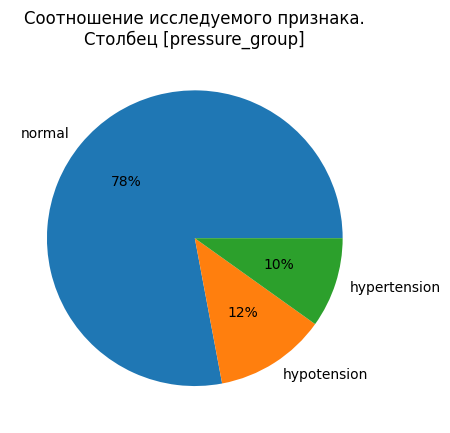

In [37]:
eda.analysis_cat_cols(X_train_exp1, ["pressure_group"])

In [38]:
X_train_exp1.sample()

,age_group,pressure_group,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate
212,older age,normal,65,90,60,6.9,98.0,70


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [39]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [40]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.014 секунд


All Done
CPU times: total: 984 ms
Wall time: 1.02 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.012,0.004,0.7,0.038


In [41]:
best_model_21 = names["LogisticRegression()"].get_best_estimator("Grid")

In [42]:
print("Лучшая модель и её параметры:\n\n", best_model_21)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [43]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [44]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.761 секунд


All Done
CPU times: total: 2.7 s
Wall time: 2.77 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.042,0.007,0.685,0.043


In [45]:
best_model_22 = names["LogisticRegression()"].get_best_estimator("Grid")

In [46]:
print("Лучшая модель и её параметры:\n\n", best_model_22)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])


## Удаление признака верхнего давления

Учтоним датасет

In [47]:
X_train_exp1_2 = X_train_exp1.drop("systolic_bp", axis=1)
X_train_exp1_2.sample()

,age_group,pressure_group,age,diastolic_bp,glucose_level,body_temperature,heart_rate
213,older age,normal,60,80,7.7,98.0,75


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [48]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6]),
    ],
    remainder="passthrough",
)

In [49]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [50]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_2,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 0.973 секунд


All Done
CPU times: total: 969 ms
Wall time: 975 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.008,0.005,0.671,0.047


In [51]:
best_model_31 = names["LogisticRegression()"].get_best_estimator("Grid")

In [52]:
print("Лучшая модель и её параметры:\n\n", best_model_31)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [53]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [54]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_2,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.584 секунд


All Done
CPU times: total: 2.52 s
Wall time: 2.59 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.028,0.005,0.664,0.046


In [55]:
best_model_32 = names["LogisticRegression()"].get_best_estimator("Grid")

In [56]:
print("Лучшая модель и её параметры:\n\n", best_model_32)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])


## Удаление признака нижнего давления

Учтоним датасет

In [57]:
X_train_exp1_4 = X_train_exp1.drop("diastolic_bp", axis=1)
X_train_exp1_4.sample()

,age_group,pressure_group,age,systolic_bp,glucose_level,body_temperature,heart_rate
170,older age,normal,55,120,12.0,98.0,70


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [58]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6]),
    ],
    remainder="passthrough",
)

In [59]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [60]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_4,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.11 секунд


All Done
CPU times: total: 1.12 s
Wall time: 1.11 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.011,0.006,0.688,0.032


In [61]:
best_model_41 = names["LogisticRegression()"].get_best_estimator("Grid")

In [62]:
print("Лучшая модель и её параметры:\n\n", best_model_41)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [63]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [64]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_2,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.352 секунд


All Done
CPU times: total: 2.36 s
Wall time: 2.35 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.035,0.006,0.664,0.046


In [65]:
best_model_42 = names["LogisticRegression()"].get_best_estimator("Grid")

In [66]:
print("Лучшая модель и её параметры:\n\n", best_model_42)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])


## Удаление обоих признаков давления

Учтоним датасет

In [67]:
X_train_exp1_5 = X_train_exp1.drop(["systolic_bp", "diastolic_bp"], axis=1)
X_train_exp1_5.sample()

,age_group,pressure_group,age,glucose_level,body_temperature,heart_rate
99,younger age,normal,17,7.0,102.0,76


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [68]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5]),
    ],
    remainder="passthrough",
)

In [69]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [70]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_5,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.074 секунд


All Done
CPU times: total: 1.06 s
Wall time: 1.08 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.011,0.007,0.671,0.029


In [71]:
best_model_51 = names["LogisticRegression()"].get_best_estimator("Grid")

In [72]:
print("Лучшая модель и её параметры:\n\n", best_model_51)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [73]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [74]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_5,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.315 секунд


All Done
CPU times: total: 2.28 s
Wall time: 2.32 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.033,0.005,0.664,0.013


In [75]:
best_model_52 = names["LogisticRegression()"].get_best_estimator("Grid")

In [76]:
print("Лучшая модель и её параметры:\n\n", best_model_52)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


## Использование совокупности признаков

Учтоним датасет

In [77]:
def get_multi_pressure(row):
    high_bp = row["systolic_bp"]
    low_bp = row["diastolic_bp"]
    return high_bp * low_bp

In [78]:
X_train_exp1_6 = X_train_exp1.copy()
X_test_exp1_6 = X_test_exp1.copy()

In [79]:
X_train_exp1_6["multi_pressure"] = X_train_exp1_6.apply(get_multi_pressure, axis=1)
X_test_exp1_6["multi_pressure"] = X_test_exp1_6.apply(get_multi_pressure, axis=1)

In [80]:
X_train_exp1_6 = X_train_exp1_6.drop(["systolic_bp", "diastolic_bp"], axis=1)
X_train_exp1_6.sample()

,age_group,pressure_group,age,glucose_level,body_temperature,heart_rate,multi_pressure
27,younger age,normal,16,6.9,98.0,76,5850


In [81]:
X_test_exp1_6 = X_test_exp1_6.drop(["systolic_bp", "diastolic_bp"], axis=1)
X_test_exp1_6.sample()

,age_group,pressure_group,age,glucose_level,body_temperature,heart_rate,multi_pressure
39,younger age,normal,17,12.0,101.0,76,8250


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [82]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6]),
    ],
    remainder="passthrough",
)

In [83]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [84]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_6,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.197 секунд


All Done
CPU times: total: 1.12 s
Wall time: 1.2 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.011,0.006,0.684,0.045


In [85]:
best_model_61 = names["LogisticRegression()"].get_best_estimator("Grid")

In [86]:
print("Лучшая модель и её параметры:\n\n", best_model_61)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [87]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [88]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_6,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.407 секунд


All Done
CPU times: total: 2.36 s
Wall time: 2.41 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.03,0.005,0.665,0.068


In [89]:
best_model_62 = names["LogisticRegression()"].get_best_estimator("Grid")

In [90]:
print("Лучшая модель и её параметры:\n\n", best_model_62)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


## Удаление признака ЧСС

Учтоним датасет

In [91]:
X_train_exp1_7 = X_train_exp1.drop("heart_rate", axis=1)
X_train_exp1_7.sample()

,age_group,pressure_group,age,systolic_bp,diastolic_bp,glucose_level,body_temperature
111,medium age,normal,32,120,90,7.0,100.0


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [92]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6]),
    ],
    remainder="passthrough",
)

In [93]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [94]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_7,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.118 секунд


All Done
CPU times: total: 1.09 s
Wall time: 1.12 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.012,0.005,0.707,0.043


In [95]:
best_model_71 = names["LogisticRegression()"].get_best_estimator("Grid")

In [96]:
print("Лучшая модель и её параметры:\n\n", best_model_71)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [97]:
preprocessors = {
    "LogisticRegression()": [smotenc, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [98]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_7,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 2.316 секунд


All Done
CPU times: total: 2.33 s
Wall time: 2.32 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.028,0.004,0.686,0.071


In [99]:
best_model_72 = names["LogisticRegression()"].get_best_estimator("Grid")

In [100]:
print("Лучшая модель и её параметры:\n\n", best_model_72)

Лучшая модель и её параметры:

 Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1], random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


## Использование оригинальных признаков

Учтоним датасет

In [101]:
X_train_exp1_8 = X_train.drop(["age_group", "pressure_group"], axis=1)
X_train_exp1_8.sample()

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate
142,40,120,85,15.0,98.0,60


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [102]:
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), [0, 1, 2, 3, 4, 5]),
    ],
    remainder="passthrough",
)

In [103]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [104]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_8,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 0.819 секунд


All Done
CPU times: total: 812 ms
Wall time: 822 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.008,0.005,0.684,0.069


In [105]:
best_model_81 = names["LogisticRegression()"].get_best_estimator("Grid")

In [106]:
print("Лучшая модель и её параметры:\n\n", best_model_81)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [107]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1206)

In [108]:
preprocessors = {
    "LogisticRegression()": [smote, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [109]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_8,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.217 секунд


All Done
CPU times: total: 1.19 s
Wall time: 1.22 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.011,0.004,0.71,0.054


In [110]:
best_model_82 = names["LogisticRegression()"].get_best_estimator("Grid")

In [111]:
print("Лучшая модель и её параметры:\n\n", best_model_82)

Лучшая модель и её параметры:

 Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


## Использование оригинальных признаков без ЧСС

Учтоним датасет

In [112]:
X_train_exp1_9 = X_train.drop(["age_group", "pressure_group", "heart_rate"], axis=1)
X_train_exp1_9.sample()

,age,systolic_bp,diastolic_bp,glucose_level,body_temperature
17,23,120,90,7.5,98.0


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [113]:
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), [0, 1, 2, 3, 4]),
    ],
    remainder="passthrough",
)

In [114]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [115]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_9,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 0.81 секунд


All Done
CPU times: total: 797 ms
Wall time: 813 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.009,0.005,0.697,0.048


In [116]:
best_model_91 = names["LogisticRegression()"].get_best_estimator("Grid")

In [117]:
print("Лучшая модель и её параметры:\n\n", best_model_91)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [118]:
preprocessors = {
    "LogisticRegression()": [smote, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [119]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_9,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.144 секунд


All Done
CPU times: total: 1.12 s
Wall time: 1.15 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.011,0.004,0.706,0.047


In [120]:
best_model_92 = names["LogisticRegression()"].get_best_estimator("Grid")

In [121]:
print("Лучшая модель и её параметры:\n\n", best_model_92)

Лучшая модель и её параметры:

 Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000))])


## Использование оригинальных признаков без diastolic_bp

Учтоним датасет

In [122]:
X_train_exp1_9 = X_train.drop(["age_group", "pressure_group", "diastolic_bp"], axis=1)
X_train_exp1_9.sample()

,age,systolic_bp,glucose_level,body_temperature,heart_rate
214,40,140,13.0,101.0,66


### Регуляризация и гиперпараметры

Уточним предобработку данных (без оверсемплинга)

In [123]:
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), [0, 1, 2, 3, 4]),
    ],
    remainder="passthrough",
)

In [124]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [125]:
%%time

res = Results()

for name in names.keys():
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_9,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 0.76 секунд


All Done
CPU times: total: 766 ms
Wall time: 764 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.008,0.005,0.695,0.022


In [126]:
best_model_91 = names["LogisticRegression()"].get_best_estimator("Grid")

In [127]:
print("Лучшая модель и её параметры:\n\n", best_model_91)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])


### Оверсемплинг

Построим новый пайп-лайн предобработки данных

In [128]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1206)

In [129]:
preprocessors = {
    "LogisticRegression()": [smote, preprocessor],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [130]:
%%time

res = Results()

for name in names.keys():
    model = 1
    model = FitPredictGo(name, scoring)
    print(f"{name}, Grid Search")
    start = time.time()
    result = model.fit_search(
        preprocessors[name],
        models[name],
        param_grids[name],
        "Grid",
        X_train_exp1_9,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_rs = round(time.time() - start, 3)
    res.update(result)
    names[name] = model
    print(f"--> Done. GridSearch Time = {time_rs} секунд" f"\n\n")
print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), Grid Search


Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

--> Done. GridSearch Time = 1.165 секунд


All Done
CPU times: total: 1.14 s
Wall time: 1.17 s


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,Grid enhanced LogisticRegression(),0.016,0.004,0.699,0.027


In [131]:
best_model_92 = names["LogisticRegression()"].get_best_estimator("Grid")

In [132]:
print("Лучшая модель и её параметры:\n\n", best_model_92)

Лучшая модель и её параметры:

 Pipeline(steps=[('smote', SMOTE(random_state=1206)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])


## Повторное обучение бейзлайн модели на новом признаке

In [133]:
model_exp1 = joblib.load("../../models/baseline_model.joblib")

In [134]:
model_exp1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['age_group',
                                                   'pressure_group']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'glucose_level',
                                                   'body_temperature',
                                                   'heart_rate'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [135]:
names = {
    "LogisticRegression()": None,
}

Построим пайп-лайны предобработки данных

In [136]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            [0, 1],
        ),
        ("num", StandardScaler(), [2, 3, 4, 5, 6, 7]),
    ],
    remainder="passthrough",
)

In [137]:
preprocessors = {
    "LogisticRegression()": [preprocessor],
}

Определим инициализационные модели для кросс-валидации

In [138]:
model_exp1.named_steps["logisticregression"]

LogisticRegression(class_weight='balanced')

In [139]:
models = {
    "LogisticRegression()": model_exp1.named_steps["logisticregression"],
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [140]:
%%time

res = Results()

for name in names.keys():
    print(f"{name}, CV")
    model = FitPredictGo(name, scoring)
    start = time.time()
    result = model.fit_cv(
        preprocessors[name],
        models[name],
        X_train_exp1,
        y_train["risk_level"],
        cv_folds,
        True,
    )
    time_cv = round(time.time() - start, 3)
    res.update(result)
    print(f"--> Done. CV Time = {time_cv} секунд")
    names[name] = model
    print()

print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

LogisticRegression(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  [0, 1]),
                                                 ('num', StandardScaler(),
                                                  [2, 3, 4, 5, 6, 7])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

--> Done. CV Time = 0.155 секунд

All Done
CPU times: total: 141 ms
Wall time: 158 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
0,LogisticRegression(),0.014,0.008,0.657,0.039


## Сохранение модели и данных для дальнейшей работы

Обновленная бейзлайн модель после подбора гиперпараметров может быть сохрананена, как финальная модель текущего исследования.

In [141]:
joblib.dump(best_model_1, "../../models/exp1_model_713.joblib")

['../../models/exp1_model_713.joblib']

Данные, на которых обучена лучшая модель текущего исследования не изменились. Сохранять их не будем.